In [1]:
import streaming
from streaming.base.format.mds.encodings import Encoding, _encodings
import numpy as np
from typing import Any
import torch
from streaming import StreamingDataset


class np32(Encoding):
    def encode(self, obj: Any) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes) -> Any:
        return np.frombuffer(data, np.float32)


_encodings["np32"] = np32
#remote_train_dir = "/root/bigdisk/project_structured_prompt/stage_2_gligen_train/grit_mds_train"
remote_val_dir = "./coco_mds_train/data"
import os
import shutil


# local_train_dir = "./local_train_dir"
# if os.path.exists(local_train_dir):
#     shutil.rmtree(local_train_dir)

local_val_dir = "./local_val_dir"
if os.path.exists(local_val_dir):
    shutil.rmtree(local_val_dir)

streaming.base.util.clean_stale_shared_memory()


# train_dataset = StreamingDataset(
#     local=local_train_dir,
#     remote=remote_train_dir,
#     split=None,
#     shuffle=True,
#     shuffle_algo="naive",
#     num_canonical_nodes=1,
# )

val_dataset = StreamingDataset(
    local=local_val_dir,
    remote=remote_val_dir,
    split=None,
    shuffle=False,
    num_canonical_nodes=1,
)

print("# PTI : Loaded dataset")
train_batch_size = 32
dataloader_num_workers = 4

# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=train_batch_size,
#     num_workers=dataloader_num_workers,
# )

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_batch_size,
    num_workers=dataloader_num_workers,
)

/root/bigdisk/cu122py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Because `predownload` was not specified, it will default to 8*batch_size if batch_size is not None, otherwise 64. Prior to Streaming v0.7.0, `predownload` defaulted to max(batch_size, 256 * batch_size // num_canonical_nodes).


# PTI : Loaded dataset


In [2]:
batch = next(iter(val_dataloader))

Because `shuffle_block_size` was not specified, it will default to max(4_000_000 // num_canonical_nodes, 1 << 18) if num_canonical_nodes is not None, otherwise 262144. Prior to Streaming v0.7.0, `shuffle_block_size` defaulted to 262144.
/root/bigdisk/cu122py310/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/root/bigdisk/cu122py310/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not su

In [3]:

from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline

model = "stabilityai/your-stable-diffusion-model"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

In [16]:
from diffusers.image_processor import VaeImageProcessor
i = 12
vae_latent = batch["vae_output"].reshape(-1, 4, 96, 96)[i:i+1].cuda()
x = vae.decode(vae_latent.cuda()).sample
img = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True, True])[0]
caption = batch['caption_output'][i]

An <|400|><|269|><|303|><|300|>astronaut flying in space, 4k, high resolution.


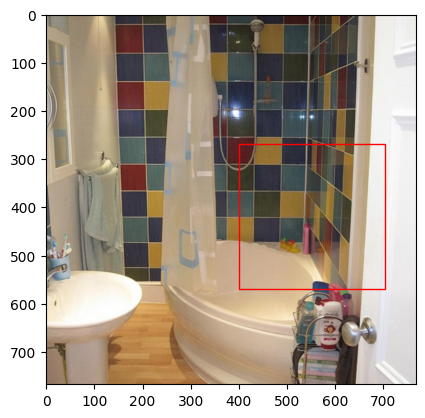

: 

In [20]:
import re
def visualize_with_bounding_boxes(image, caption_structure):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    print(caption)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # extract noun chunks from caption_structure
    # capture <|(x_min)|><|(y_min)|><|(x_max)|><|(y_max)|>
    noun_chunks = re.findall(r"<\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\>", caption_structure)
    noun_chunks = [(int(x_min), int(y_min), int(w), int(h)) for x_min, y_min, w, h in noun_chunks]
    
    
    # Plot bounding boxes
    for chunk in noun_chunks:
        x_min, y_min, w, h = chunk
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

caption = "An <|400|><|269|><|303|><|300|>astronaut flying in space, 4k, high resolution."
visualize_with_bounding_boxes(img, caption)